# Выбор локации для скважины

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Структура данных:
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

## Подготовка к работе

In [1]:
!pip install phik -q
!pip install numpy==1.23.1 -q
!pip install numba -U -q
!pip install scikit-learn -U -q 
!pip install scipy -U -q 
!pip install shap -U -q

In [2]:
RANDOM_STATE = 2024

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.metrics import roc_auc_score, root_mean_squared_error
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import confusion_matrix

from scipy import stats as st

import shap

from phik.report import plot_correlation_matrix
from phik import report

import warnings

state = np.random.RandomState(RANDOM_STATE)

## Загрузка и обзор данных
### Загрузка данных

In [3]:
geo0 = pd.read_csv('...')
geo1 = pd.read_csv('...')
geo2 = pd.read_csv('...')

### Обзор данных

In [4]:
display(geo0.head())
display(geo0.info())
display(geo1.head())
display(geo1.info())
display(geo2.head())
display(geo2.info())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Как видно данные совпадают с предоставленным описанием структуры данных. Типы данных выбраны корректно

## Предобработка данных

В этом разделе рассмотрим пропуски в данных и проведем необходимые преобразования типов и добавим необходимые столбцы.

### Рассмотрение пропусков в данных

Рассмотрим в каких каких столбцах сколько пропусков находится

In [5]:
print('Число пропусков в geo0')
print(geo0.isna().sum())

print('Число пропусков в quit_train')
print(geo1.isna().sum())

print('Число пропусков в test')
print(geo2.isna().sum())

Число пропусков в geo0
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Число пропусков в quit_train
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Число пропусков в test
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Пропуски в данных отсутствуют

### Дубликаты в данных

Рассмотрим есть ли в данных скаважины с повторяющимися `id`, рассматривать будем каждый регион отдельно т.к. неизвестно могут ли у скважин в разных регионах быть одинаковые `id`

In [6]:
print('Число дублирующихся id в geo0:', geo0['id'].duplicated().sum())
print('Число дублирующихся id в geo1:', geo1['id'].duplicated().sum())
print('Число дублирующихся id в geo2:', geo2['id'].duplicated().sum())

display(geo0[geo0['id'].duplicated()])
display(geo1[geo1['id'].duplicated()])
display(geo2[geo2['id'].duplicated()])

Число дублирующихся id в geo0: 10
Число дублирующихся id в geo1: 4
Число дублирующихся id в geo2: 4


,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


В данных присутсвуют повторяющиеся `id`, т.к. предполагается что они должны быть уникальны, удалим эти дубликаты

In [7]:
geo0 = geo0.drop_duplicates('id', keep='first')
geo1 = geo1.drop_duplicates('id', keep='first')
geo2 = geo2.drop_duplicates('id', keep='first')

print('Число дублирующихся id в geo0:', geo0['id'].duplicated().sum())
print('Число дублирующихся id в geo1:', geo1['id'].duplicated().sum())
print('Число дублирующихся id в geo2:', geo2['id'].duplicated().sum())

Число дублирующихся id в geo0: 0
Число дублирующихся id в geo1: 0
Число дублирующихся id в geo2: 0


### Итоги предобработки данных

В ходе предобработки пропуски в данных обнаружены не были, данные совпадают с предоставленной структурой данных. Были найдены и удалены дублирующиеся `id` скважин

## Исследовательский анализ данных
Опишем общую информацию о распределениях данных в таблицах

### geo0

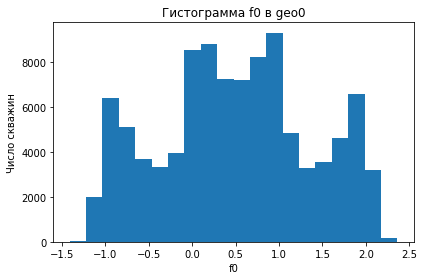

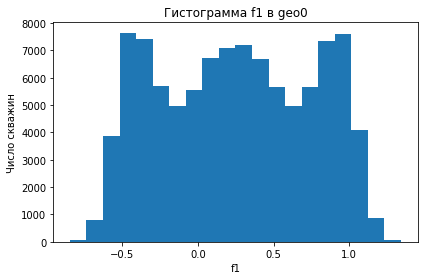

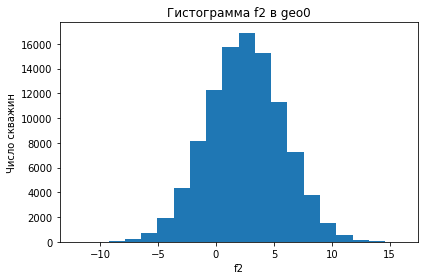

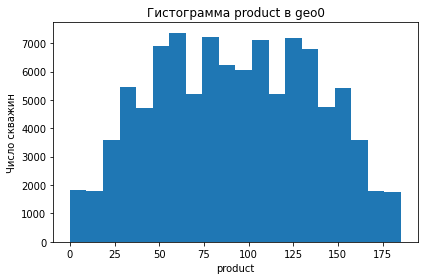

In [8]:
df = geo0

for c in df.drop('id', axis=1):
    fig, ax = plt.subplots()
    ax.hist(df[c], bins=20)
    
    ax.set_xlabel(c)
    ax.set_ylabel('Число скважин')
    ax.set_title('Гистограмма '+c+' в geo0')
    fig.tight_layout()
    plt.show()

В данном регионе `f2` и `product` распределены нормально, `f0` имеет 4 пика, а `f1` 3 пика.

### geo1

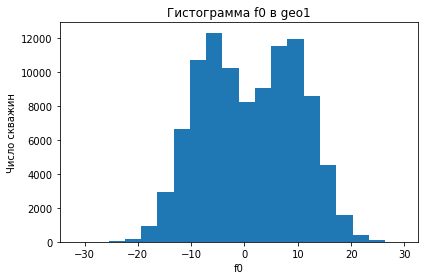

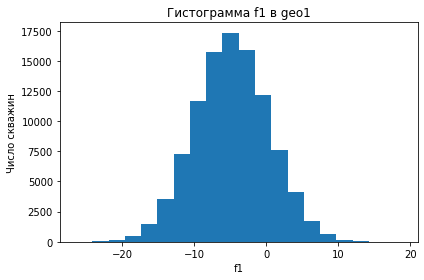

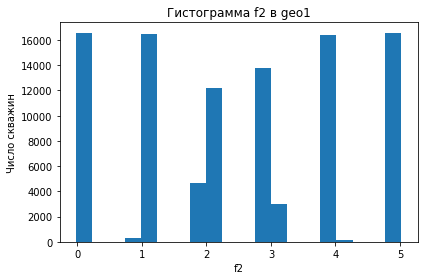

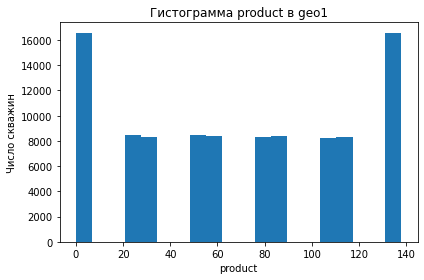

In [9]:
df = geo1

for c in df.drop('id', axis=1):
    fig, ax = plt.subplots()
    ax.hist(df[c], bins=20)
    
    ax.set_xlabel(c)
    ax.set_ylabel('Число скважин')
    ax.set_title('Гистограмма '+c+' в geo1')
    fig.tight_layout()
    plt.show()

В данном регионе параметр `f1` распределен нормально, `f0` имеет два пика, а все остальные параметры ведут себя практически дискретно.

### geo2

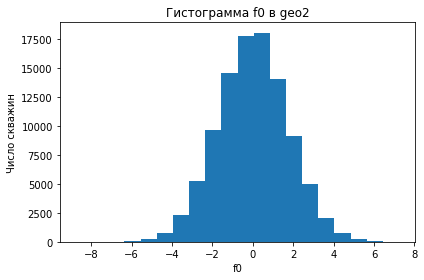

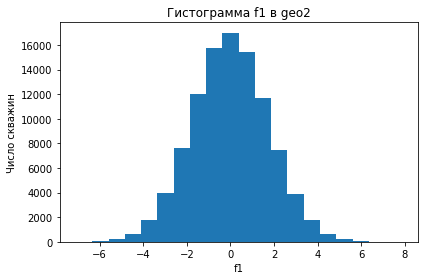

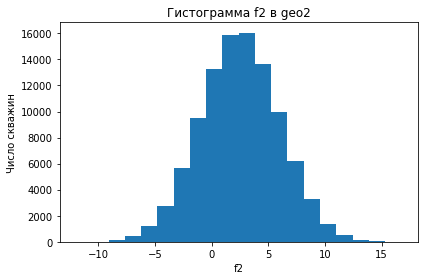

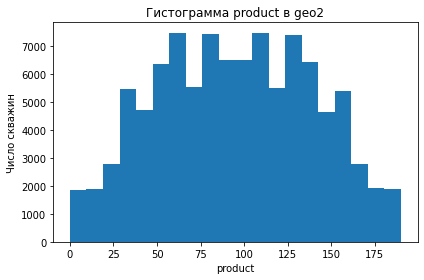

In [10]:
df = geo2

for c in df.drop('id', axis=1):
    fig, ax = plt.subplots()
    ax.hist(df[c], bins=20)
    
    ax.set_xlabel(c)
    ax.set_ylabel('Число скважин')
    ax.set_title('Гистограмма '+c+' в geo2')
    fig.tight_layout()
    plt.show()

Для данного региона все параметры распределены нормально.

### Корреляционный анализ

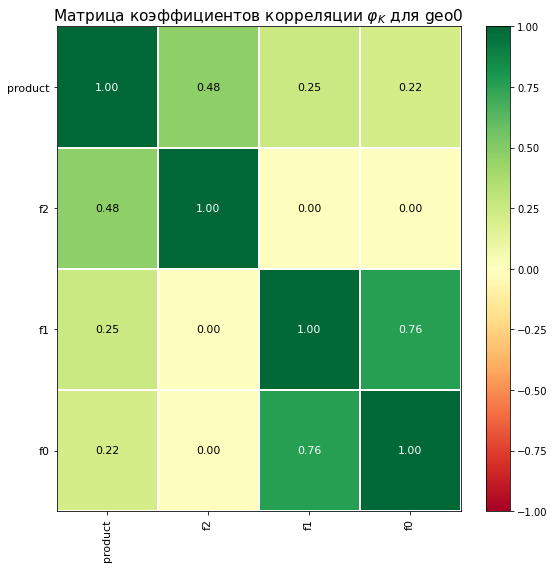

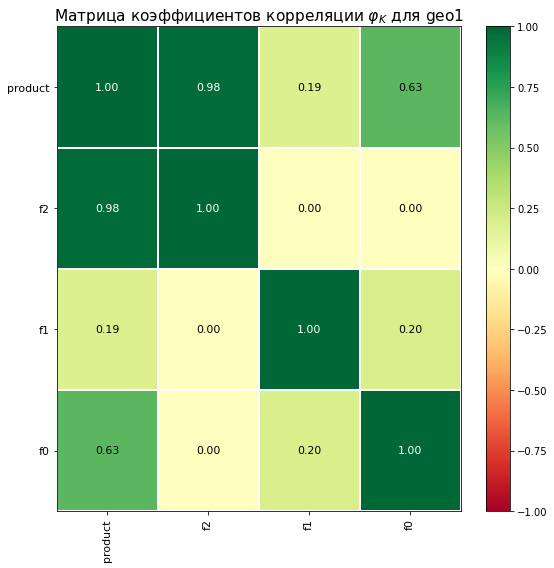

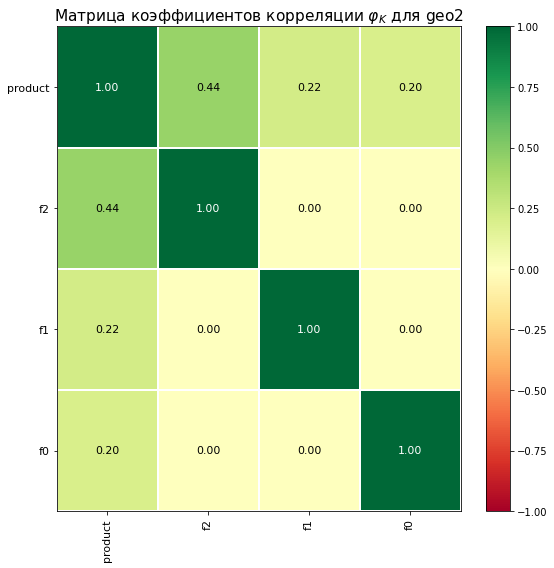

In [11]:
df = geo0.drop('id', axis=1)

# вычисление коэффициентов корреляции phi для датафрейма
phik_overview = df.phik_matrix(interval_cols=df.columns)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица коэффициентов корреляции $\varphi_K$ для geo0",
    fontsize_factor=1.1,
    figsize=(8,8)
)

df = geo1.drop('id', axis=1)

# вычисление коэффициентов корреляции phi для датафрейма
phik_overview = df.phik_matrix(interval_cols=df.columns)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица коэффициентов корреляции $\varphi_K$ для geo1",
    fontsize_factor=1.1,
    figsize=(8,8)
)

df = geo2.drop('id', axis=1)

# вычисление коэффициентов корреляции phi для датафрейма
phik_overview = df.phik_matrix(interval_cols=df.columns)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица коэффициентов корреляции $\varphi_K$ для geo2",
    fontsize_factor=1.1,
    figsize=(8,8)
)

Как видно, для разных регионов различны коэффициенты корреляции входных признаков и целевого признака `product`, однако самым значимым можно назвать признак `f2`


## Предсказание объёма запасов нефти

В данном разделе обучим модели линейной регрессии для предсказания объема запасов нефти в каждом регионе по отдельности

### Подготовка данных

In [12]:
data_preprocessor = ColumnTransformer(
    [
        ('scaler', MinMaxScaler(), ['f0', 'f1', 'f2'])
    ], 
    remainder='passthrough'
)
###############################################
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
################################################
parameters = [
    #LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__scaler': [StandardScaler(), MinMaxScaler()]
    }
] 
###############################################
dfs = [geo0, geo1, geo2]
X_trains = []
y_trains = []
X_tests = []
y_tests = []

for df in dfs:
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['id', 'product'], axis=1), df['product'], test_size=0.25, random_state=RANDOM_STATE)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

### Обучение моделей

В данном разделе обучим модели на подготовленных данных. Качество будем оценивать метрикой RMSE

In [13]:
results = []

for i in range(3):
    grid_search = GridSearchCV(
    pipe_final, 
    parameters, 
    cv = 5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
    )

    grid_search.fit(X_trains[i], y_trains[i])
    
    print('Метрика RMSE лучшей моделей при кросс-валидации для geo'+str(i)+':', abs(grid_search.best_score_))
    print('Параметры лучшей моделей при кросс-валидации для geo'+str(i)+':', grid_search.best_params_)
    results.append(grid_search)

Метрика RMSE лучшей моделей при кросс-валидации для geo0: 37.75351297068785
Параметры лучшей моделей при кросс-валидации для geo0: {'models': LinearRegression(), 'preprocessor__scaler': StandardScaler()}
Метрика RMSE лучшей моделей при кросс-валидации для geo1: 0.8912173884494695
Параметры лучшей моделей при кросс-валидации для geo1: {'models': LinearRegression(), 'preprocessor__scaler': StandardScaler()}
Метрика RMSE лучшей моделей при кросс-валидации для geo2: 40.04543830219078
Параметры лучшей моделей при кросс-валидации для geo2: {'models': LinearRegression(), 'preprocessor__scaler': StandardScaler()}


### Оценка качества моделей и их адекватности

In [14]:
res_df = {'Регион':[], 'RMSE на кросс-валидации при обучении':[], 'RMSE на валидационной выборке':[], 'RMSE константной модели на валидационной выборке':[], 'Средний предсказанный запас сырья на валидационной выборке':[], 'Средний истинный запас сырья на валидационной выборке':[]}

for i in range(3):
    res_df['Регион'].append('geo'+str(i))
    res_df['RMSE на кросс-валидации при обучении'].append(abs(results[i].best_score_))
    res_df['RMSE на валидационной выборке'].append(abs(results[i].score(X_tests[i], y_tests[i])))
    res_df['RMSE константной модели на валидационной выборке'].append(root_mean_squared_error([y_trains[i].mean()]*len(y_tests[i]), y_tests[i]))
    res_df['Средний предсказанный запас сырья на валидационной выборке'].append(results[i].predict(X_tests[i]).mean())
    res_df['Средний истинный запас сырья на валидационной выборке'].append(y_tests[i].mean())
display(pd.DataFrame(res_df))

,Регион,RMSE на кросс-валидации при обучении,RMSE на валидационной выборке,RMSE константной модели на валидационной выборке,Средний предсказанный запас сырья на валидационной выборке,Средний истинный запас сырья на валидационной выборке
0,geo0,37.753513,37.517361,44.294884,92.472684,92.619129
1,geo1,0.891217,0.888037,45.965805,68.545588,68.559935
2,geo2,40.045438,40.088628,44.791054,94.941035,94.964757


Как видно среди обученных моделей хороший результат показала только для 1 региона. Значения метрики моделей для 0 и 2 регионов не сильно лучше метрики модели выдающей среднее значение, видимо линейная модель не слишком подходит для имеющихся данных, но по ТЗ ограничены использованием данной модели. Тем не менее средние для предсказанных и истинных значений близки.

## Расчет прибыли

### Подготовка к расчёту прибыли

Для расчета прибыли имеются следующие вводные:
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [15]:
BUDGET = 10**10
PRICE = 450000
N_INVESTIGATE = 500
N_DEVELOP = 200

In [16]:
BUDGET_PER_WELL = BUDGET / N_DEVELOP

# min_product*price = budget_per_well

MIN_PRODUCT = BUDGET_PER_WELL / PRICE

print('Минальный объем запасов для выхода в 0:', round(MIN_PRODUCT,2))

Минальный объем запасов для выхода в 0: 111.11


Как видно минимальный объем для безубыточности больше чем средние запасы в каждом регионе (особенно выделяется 1 регион, там средний объем почти вдвое меньше необходимого), таким образом нужно тщательно отбирать места для разработки

In [17]:
def profit(product):
    return product*PRICE

def net_profit(product):
    return (product-MIN_PRODUCT)*PRICE

def calc_profit(real_product_list, predicted_product_list, n_develop):
    #n_develop лучших скважин по предсказаниям
    predicted_product_list = pd.Series(predicted_product_list).sort_values(ascending=False)
    #реальный обьем запасов лучших скважин по предсказаниям
    real_product_list = real_product_list[predicted_product_list.index][:n_develop]
    print(len(real_product_list))
    return profit(real_product_list.sum())

### Расчёт прибыли и рисков 

В данном подразделе методом bootstrap (с 1000 выборок) рассчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [18]:
regions_profit_bootstrap = []

for region in range(3):
    # Для каждого региона берем 1000 выборок по 500 элементов из валидационной выборки
    values_p = []

    for _ in range(1000):
        #Берем 500 скважин
        X_subsample = X_tests[region].sample(n=N_INVESTIGATE,replace=True, random_state=state)
        # Это немного костыль для сохранения индексов
        X_subsample['prediction'] = results[region].predict(X_subsample)
        #Выбираем 200 лучших скважин по предсказаниям и считаем их прибыль по реальным данным
        values_p.append(calc_profit(y_tests[region][X_subsample.index], X_subsample['prediction'], N_DEVELOP))
        
    values_p = pd.Series(values_p)
    regions_profit_bootstrap.append(values_p)

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


In [22]:
bootstrap_results = []
for region in range(3):
    bootstrap_results.append([
        regions_profit_bootstrap[region].mean(),
        regions_profit_bootstrap[region].mean()-BUDGET,
        f'({round(regions_profit_bootstrap[region].quantile(0.025),2)},{round(regions_profit_bootstrap[region].quantile(0.975),2)})',
        f'({round(regions_profit_bootstrap[region].quantile(0.025)-BUDGET,2)},{round(regions_profit_bootstrap[region].quantile(0.975)-BUDGET,2)})',
        #st.t.interval(confidence=0.95,df=len(regions_profit_bootstrap[region])-1,loc=regions_profit_bootstrap[region].mean(), scale=regions_profit_bootstrap[region].sem()),
        regions_profit_bootstrap[region][regions_profit_bootstrap[region]-BUDGET<0].count()/1000
        #st.norm.cdf(BUDGET, regions_profit_bootstrap[region].mean(), regions_profit_bootstrap[region].std())
    ])

In [23]:
display(pd.DataFrame(bootstrap_results, columns=['Средняя выручка', 'Средняя прибыль','95% доверительный интервал выручки', '95% доверительный интервал прибыли', '% риска убытков'], index=['geo0', 'geo1', 'geo2']))

,Средняя выручка,Средняя прибыль,95% доверительный интервал выручки,95% доверительный интервал прибыли,% риска убытков
geo0,1.046732e+10,4.673151e+08,"(9905186378.63,11027188688.9)","(-94813621.37,1027188688.9)",0.046
geo1,1.047464e+10,4.746430e+08,"(10068145487.32,10910118193.74)","(68145487.32,910118193.74)",0.004
geo2,1.037721e+10,3.772118e+08,"(9828159905.15,10945091653.27)","(-171840094.85,945091653.27)",0.077


Как видно для всех 3 регионов средняя доходность немного (3-5%) больше исходного бюджета. Также для всех 3 регионов риск убытков не превышает 8%, однако допустимому уровеню риска в 2.5% удовлетворяют только 1 регион, при этом он является минимальным среди всех регионов (0.4%)

Также заметим, что выше всего средняя доходность в 1 регионе (475 млн.р. чистыми)

## Выводы



В данной работе исследовались данные об объеме запасов нефти в 3 регионах. В ходе работы был проведен исслеловательский анализ данных и обучены 3 модели линейной регрессии (по 1 для каждого региона)

Отметим что качество обученных моделей является едва ли удовлетворительным, модели для 0 и 2 регионов показали результат немногим лучше константной модели, тем не менее модель для 1 региона показала себя хорошо (по метрике RMSE)

Также методом bootstrap были рассчитаны средняя прибыль для набора в 200 скважин из выборки в 500, доверительный 95% интервал для соответствующего распределения и риски убытков

Таким образом на основе проведенного анализа можно рекомендовать 1 регион как приоритетный. Данная рекомендация основана на том, что:
- Средняя доходность в данном регионе самая высокая
- Это единственный регион с допустимым уровнем риска.

### Дополнительные изыскания
- Необходимо изменить тип модели для 0 и 2 регионов для повышения качества обучения, возможно это изменит приоритетность регионов
- Перерасчитать доходность и риски для новых моделей